[View in Colaboratory](https://colab.research.google.com/github/byebye/MNIST/blob/master/MNIST.ipynb)

# Install PyTorch

In [1]:
# https://pytorch.org/
!pip3 install torch torchvision

# Import PyTorch and check CUDA availability

In [0]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable

use_cuda = True
if use_cuda:
  assert(torch.cuda.is_available())

# Initialize parameters

In [0]:
input_size    = 784   # The image size = 28 x 28 = 784
num_classes   = 10    # The number of output classes. In this case, from 0 to 9
num_epochs    = 20     # The number of times entire dataset is trained
train_size = 38000
validation_size = 4000
batch_size    = 64    # The size of input data took for one iteration
learning_rate = 1e-3  # The speed of convergence

# Load Kaggle MNIST dataset from Google Drive

In [0]:
# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

train_file_id = '12WsWKOlQ-IHlU4jK35xNJ3koG_CL6l5z'
test_file_id = '12MIA-FGEU4Ahtyqd_lDarSF0_cNenOj1'

train_file = drive.CreateFile({'id': train_file_id})
test_file = drive.CreateFile({'id': test_file_id})

# Create & upload a text file.
# uploaded = drive.CreateFile({'title': 'Sample file.txt'})
# uploaded.SetContentString('Sample upload file content')
# uploaded.Upload()
test_file.GetContentFile('test.csv')
train_file.GetContentFile('train.csv')

In [0]:
import pandas as pd

kaggle_train_file = pd.read_csv('train.csv', dtype='uint8')
kaggle_test_file = pd.read_csv('test.csv', dtype='uint8')

In [6]:
print(kaggle_train_file.shape)
print(kaggle_test_file.shape)

(42000, 785)
(28000, 784)


In [0]:
Y = kaggle_train_file["label"].values
X = kaggle_train_file.drop(labels=["label"], axis=1).values
X = X.reshape(-1, 1, 28, 28)
del kaggle_train_file

In [28]:
import seaborn as sns
import numpy as np

print(np.max(X),np.mean(X))
#g = sns.countplot(X.flatten())
#h = sns.countplot(Y)
# np.histogram(X, bins=np.array(range(256)))

255 33.408911169825075


In [29]:
#X = X.reshape(-1, 1, 28, 28)
print(X.shape)

from sklearn.model_selection import train_test_split
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,
                                                    train_size=train_size,
                                                    test_size=validation_size,
                                                    stratify=Y)

(42000, 1, 28, 28)


(28, 28)


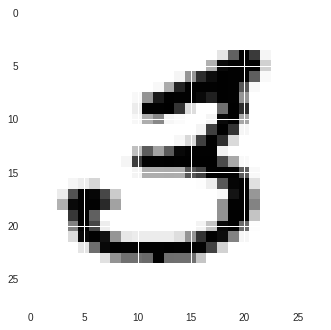

In [66]:
g = plt.imshow(X_train[0][0,:,:])

In [0]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

class MnistDataset(Dataset):
    def __init__(self, X, Y=None):
        self.X = torch.from_numpy(X / 255.0).float()
        self.Y = None
        if Y is not None:
            self.Y = torch.from_numpy(Y)
        self.len = len(X)

    def __getitem__(self, i):
        x = self.X[i]
        if self.Y is None:
            return x
        y = self.Y[i]
        return x, y

    def __len__(self):
        return self.len


In [0]:
train_dataset = MnistDataset(X_train, Y_train)
validation_dataset = MnistDataset(X_validation, Y_validation)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=4, pin_memory=True)

validation_loader = DataLoader(
    dataset=validation_dataset, batch_size=batch_size, shuffle=False,
    num_workers=4, pin_memory=True)

# Download MNIST Dataset from official website
http://yann.lecun.com/exdb/mnist/

In [0]:
# train_dataset = dsets.MNIST(root='./data',
#                            train=True,
#                            transform=transforms.ToTensor(),
#                            download=True)

# test_dataset = dsets.MNIST(root='./data',
#                            train=False,
#                            transform=transforms.ToTensor())

# Load the Dataset

**Note**: We shuffle the loading process of `train_dataset` to make the learning process independent of data order, but the order of `test_loader` remains so as to examine whether we can handle unspecified bias order of inputs.


In [0]:
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                           batch_size=batch_size,
#                                           shuffle=True)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=batch_size,
#                                           shuffle=False)

# Build Neural Network

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


def build_cnn():
    return nn.Sequential(
#         nn.BatchNorm2d(1),
        nn.Conv2d(1, 32, 5),
        nn.ReLU(),
        nn.Conv2d(32, 32, 5),
        nn.ReLU(),
        nn.MaxPool2d((2, 2)),
        nn.Dropout(0.25),

        nn.Conv2d(32, 64, 3),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d((2, 2)),
        nn.Dropout(0.25),

        Flatten(),
        nn.Linear(576, 256),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(256, 10),
        nn.Softmax(dim=1))

# Instantiate the CNN

In [0]:
net = build_cnn()
if use_cuda:
  net.cuda()

In [34]:
import torch.nn.init as init

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform(m.weight, gain=init.calculate_gain('relu'))

net.apply(weights_init)

Sequential(
  (0): Conv2d (1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d (32, 32, kernel_size=(5, 5), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (5): Dropout(p=0.25)
  (6): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (11): Dropout(p=0.25)
  (12): Flatten(
  )
  (13): Linear(in_features=576, out_features=256)
  (14): ReLU()
  (15): Dropout(p=0.5)
  (16): Linear(in_features=256, out_features=10)
  (17): Softmax()
)

# Choose the Loss Function and Optimizer

Loss function (**criterion**) decides how the output can be compared to a class, which determines how good or bad the neural network performs. And the **optimizer** chooses a way to update the weight in order to converge to find the best weights in this neural network.

In [0]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

optimizer = torch.optim.RMSprop(params=net.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5,
                                                    patience=3,
                                                    min_lr=0.00001)

# Training the CNN Model

In [0]:
predicted_train = []
true_train = []
predicted_test = []
true_test = []

def is_last_epoch(epoch):
    return epoch + 1 == num_epochs

In [49]:
!pip install tqdm
from tqdm import tqdm

    100% |████████████████████████████████| 51kB 3.8MB/s 


In [0]:
losses = []

def train_net(epoch):
    net.train()  # set the net to "training mode"
    
    for i, (images, labels) in enumerate(tqdm(train_loader, desc='Training #{}'.format(epoch))):   # Load a batch of images with its (index, data, class)
        # Conv2d expects data of shape (N, C, H, W) where N is batch size, C is channels, H is height, W is width
        # images = images.view(-1, 1, 28, 28) # change images dimension from [64, 768] to a matrix [64, 1, 28, 28]
        images = Variable(images)
        labels = Variable(labels)
        
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()                             # Intialize the hidden weight to all zeros
        outputs = net(images)                             # Forward pass: compute the output class given a image
        loss = criterion(outputs, labels)                 # Compute the loss: difference between the output class and the pre-given label
        loss.backward()                                   # Backward pass: compute the weight
        optimizer.step()                                  # Optimizer: update the weights of hidden nodes
        
        global losses
        losses.append(loss.data[0])
#         if (i+1) % 100 == 0:                              # Logging
#             print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
#                  %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

In [0]:
accuracy = []

def validate_net(epoch):
    net.eval()  # set the model to "testing mode" (won't update parameters)

    correct = 0
    total = 0
    for images, labels in tqdm(validation_loader, desc='Validating #{}'.format(epoch)):
        # images = images.view(-1, 1, 28, 28)
        images = Variable(images)
        
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()


        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1) # Choose the best class from the output: The class with the best score
        total += labels.size(0)                    # Increment the total count
        correct += (predicted == labels).sum()     # Increment the correct count
        
        if is_last_epoch(epoch):
            global predicted_test
            global true_test
            true_test += labels.cpu().numpy().tolist()
            predicted_test += predicted.cpu().numpy().tolist()
    
    
    acc = correct / total
    lr_scheduler.step(acc)
    global accuracy
    accuracy.append(acc)
    #print('Accuracy: {}'.format(acc))

In [58]:
for epoch in range(num_epochs):
    train_net(epoch)
    validate_net(epoch)

Training #4:  55%|█████▌    | 329/594 [00:04<00:03, 75.79it/s]

Training #8:  65%|██████▍   | 385/594 [00:04<00:02, 77.44it/s]

Training #12:  59%|█████▉    | 351/594 [00:04<00:03, 75.41it/s]

Training #16:  59%|█████▉    | 350/594 [00:04<00:03, 75.87it/s]

Validating #19: 100%|██████████| 63/63 [00:00<00:00, 109.17it/s]


# Plot the loss and accuracy curves for training and validation 

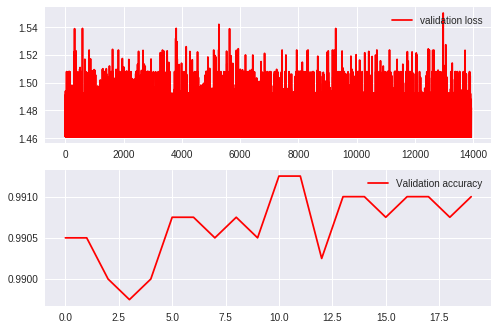

In [68]:

fig, ax = plt.subplots(2,1)
# ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(losses, color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

# ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(accuracy, color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Plot Confusion Matrix

In [0]:
from matplotlib import pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues,
                          filesave=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)
    plt.figure(figsize=(7, 7))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes)

    yticks = []
    for i in (range(cm.shape[0])):
        acc = cm[i, i] / np.sum(cm[i])
        yticks.append("{} (acc={:.10f})".format(i, acc))

    plt.yticks(tick_marks, yticks)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    if filesave is None:
        plt.tight_layout()
#         plt.show()
    else:
        plt.savefig(filesave, bbox_inches='tight')

Confusion matrix, without normalization


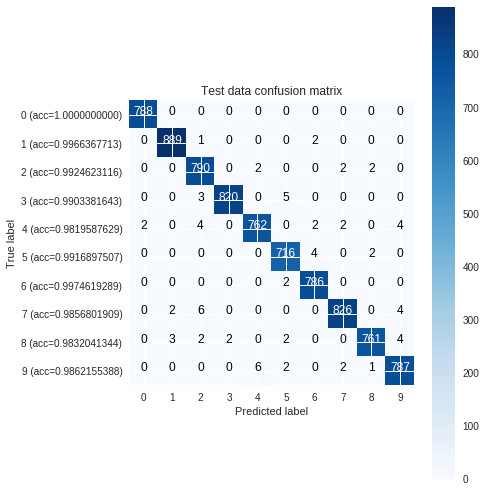

In [70]:
from sklearn.metrics import confusion_matrix

# cnf_matrix = confusion_matrix(true_train, predicted_train)
# plot_confusion_matrix(cm=cnf_matrix, classes=list(range(10)),
#                       title='Train data confusion matrix')

cnf_matrix = confusion_matrix(true_test, predicted_test)
plot_confusion_matrix(cm=cnf_matrix, classes=list(range(10)),
                      title='Test data confusion matrix')

# Testing the CNN Model

Similar to training the neural network, we also need to load batches of test images and collect the outputs. The differences are that:

1. No loss & weights calculation
2. No weights update
3. Has correct prediction calculation


In [0]:
net.eval() 
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, 28*28))
    
    if use_cuda and torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    
    
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
    total += labels.size(0)                    # Increment the total count
    correct += (predicted == labels).sum()     # Increment the correct count
    
print('Accuracy of the network on the 10K test images: %d %%' % (100 * correct / total))

# Save the trained FNN Model for future use

We save the trained model as a pickle that can be loaded and used later.

In [0]:
torch.save(net.state_dict(), 'cnn_model.pkl')